<a href="https://www.kaggle.com/code/abhirupghosh184098/deep-learning-on-the-titanic?scriptVersionId=114517091" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Competition: [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)
Predict which passengers are transported to an alternate dimension





## [Short Description](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In the year 2912, exactly a 1000 years on from the sinking of the legendary ship Titanic, a spaceship by the same name might be heading for a similar fate. On its maiden voyage transporting around 13000 emigrants to three newly habitable exoplanets orbiting nearby stars, at around Alpha Centauri (~4 lys away), it has collided with a spacetime anomaly which has transported half of the passengers to an alternate dimension. In this "Getting Started" competition, we are tasked with predicting which passengers were transported (and which weren't) using records left in the spaceship's damaged computer system.

## Evaluation

Submissions are evaluated based on their [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), the percentage of predicted labels that are correct. Accuracy is defined generally as:

$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$

or in the case of binary classification:

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

where (T,F): True/False and (P,N): Positive/Negative

## Data
### Training set: train.csv
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Test set: test.csv
Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

### Submission: sample_submission.csv
A submission file in the correct format.
* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

## Disclaimer
I will be working on this notebook over the coming weeks, with the evential aim of implementing a keras/tensorflow deep learning classification architechture to make the predictions, as covered in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) Kaggle-learn course. Along the way, I would be using lessons learnt in other Kaggle courses, like [Data Cleaning](https://www.kaggle.com/learn/data-cleaning) and [Feature Engineering](https://www.kaggle.com/learn/feature-engineering). In the end I hope this notebook will provide a guide in taking us through a complete journey in deep learning starting from basics like data loading and preparation all the way to making competitive predictions.


# Preliminaries: Dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import os
import warnings
warnings.simplefilter('ignore', FutureWarning)
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from xgboost import XGBClassifier

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex6 import *

from tensorflow import keras
from tensorflow.keras import layers

# Competition Data

In [3]:
data_dir = Path("../input/spaceship-titanic/")
df_train = pd.read_csv(data_dir / "train.csv")
df_test = pd.read_csv(data_dir / "test.csv")

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data Preprocessing/Preparation

## Data Cleaning

In [5]:
###################################
# Data cleaning
###################################

def clean(df):
    # Some columns should be integers but assigned as floats, eg,
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck. These
    # represent the number of passengers, and can't be fractional.
    # We also add 'Age' to this, because by the looks of it, it has 
    # been rounded up to the nearest integer. Returning them to 
    # integers saves memory
    
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']:
        df[col] = df[col].fillna(0).astype(int)
        
    return df

## Data Encoding: Encode the Statistical Data Type

The numeric features are already encoded correctly (`float64`), but the categoricals we'll need to do ourselves. Unlike the case for the [housing prices problem](https://www.kaggle.com/code/abhirupghosh184098/advanced-regression-a-beginner-s-perspective?scriptVersionId=113811799&cellId=10), we do not have **ordinal (ordered)** categorical features here. All the categorical variables are **nominative (unordered)** categorical features.

In [6]:
###################################
# Data Encoding: Encode the Statistical Data Type
###################################

# The nominative (unordered) categorical features
features_nom = ["PassengerId", "HomePlanet", "CryoSleep", 
                "Cabin", "Destination", "VIP", "Name"]

def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories: None present
    return df

**NOTE:** If we engineer features, we might need to encode the new features.

## Data Imputing: Handle Missing Values

In [7]:
###################################
# Handle Missing Values
###################################

# impute 0 for missing numeric values and 
# "None" for missing categorical values.

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load-clean-encode-impute

As part of our data preparation, we will [source]:

* Load competition data
* Clean the data to fix any errors or inconsistencies
* Encode the statistical data type (numeric, categorical)
* Impute any missing values

In [8]:
def load_data():
    # Read data
    data_dir = Path("../input/spaceship-titanic/")
    df_train = pd.read_csv(data_dir / "train.csv")
    df_test = pd.read_csv(data_dir / "test.csv")

    # Preprocessing
    # Cleaning
    df_train = clean(df_train)
    df_test = clean(df_test)
    
    # Encoding
    df_train = encode(df_train)
    df_test = encode(df_test)
    
    # Imputing
    df_train = impute(df_train)
    df_test = impute(df_test)

    return df_train, df_test

In [9]:
df_train, df_test = load_data()

In [10]:
df_train.info()
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   category
 1   HomePlanet    8693 non-null   category
 2   CryoSleep     8693 non-null   category
 3   Cabin         8693 non-null   category
 4   Destination   8693 non-null   category
 5   Age           8693 non-null   int64   
 6   VIP           8693 non-null   category
 7   RoomService   8693 non-null   int64   
 8   FoodCourt     8693 non-null   int64   
 9   ShoppingMall  8693 non-null   int64   
 10  Spa           8693 non-null   int64   
 11  VRDeck        8693 non-null   int64   
 12  Name          8693 non-null   category
 13  Transported   8693 non-null   bool    
dtypes: bool(1), category(7), int64(6)
memory usage: 1.4 MB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41,True,0,6819,0,1643,74,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18,False,0,0,0,0,0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26,False,0,0,1872,1,0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32,False,0,1049,0,353,3235,Celeon Hontichre,False


# Baseline

We start with establishing a baseline model. This baseline model, or more specifically, the score from this baseline model is what we would use to judge the performance of our feature engineering against. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

## Details of baseline Model:
* Model: XGBClassifier()
* Evaluation: Classification Accuracy (same as competition evaluation metric)

In [11]:
def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Evaluation: Accuracy
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    # Return the mean score (accuracy)
    return score.mean()

In [12]:
X = df_train.copy()
y = X.pop("Transported")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} Accuracy")

Baseline score: 0.61947 Accuracy


# Feature Engineering

A lot of the material in this section is borrowed from [my Housing Prices notebook](https://www.kaggle.com/code/abhirupghosh184098/advanced-regression-a-beginner-s-perspective/#Feature-engineering), which was itself inspired by the [Feature Engineering course](https://www.kaggle.com/learn/feature-engineering). Hence I am not repeating the detailed documentation I had put down there. I will also not be following all the steps I performed in forensic detail in the other notebook. **The focus of this notebook would be deep learning using tensorflow/keras** and I would try to get to it as quickly as possible. In this section, I just restrict myself to feature breakdown.

## Feature Breakdown

Some of the features, like `PassengerId`, `Cabin` and `Name`, consist of information that are grouped together. For example: 
* `PassengerId` has a form `gggg_pp`, which can be split up into the Group `gggg` and the GroupNo `pp`
* `Cabin` takes the form `deck`/`num`/`side`, where `side` can be either P for Port or S for Starboard
* `Name` consists of two parts: first and last names

In [13]:
def break_down(df):
    X = pd.DataFrame()
    
    # Passengerid
    X[['Group', 'GroupNo']] = df['PassengerId'].str.split('_', 1, expand=True)
    # convert to categorical variable
    X["Group"] = X["Group"].astype("category")
    X["GroupNo"] = X["GroupNo"].astype("category")
    
    # Cabin
    X[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
    # convert to categorical variable
    X["deck"] = X["deck"].astype("category") 
    X["num"] = X["num"].astype("category")
    X["side"] = X["side"].astype("category")
    
    # Name
    X[['FirstName','LastName']] = df['Name'].str.split(' ', expand=True)
    # convert to categorical variable
    X["FirstName"] = X["FirstName"].astype("category")
    X["LastName"] = X["LastName"].astype("category")
    
    return X

display(break_down(df_train).head())
break_down(df_train).info()

,Group,GroupNo,deck,num,side,FirstName,LastName
0,0001,01,B,0,P,Maham,Ofracculy
1,0002,01,F,0,S,Juanna,Vines
2,0003,01,A,0,S,Altark,Susent
3,0003,02,A,0,S,Solam,Susent
4,0004,01,F,1,S,Willy,Santantines


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Group      8693 non-null   category
 1   GroupNo    8693 non-null   category
 2   deck       8693 non-null   category
 3   num        8494 non-null   category
 4   side       8494 non-null   category
 5   FirstName  8693 non-null   category
 6   LastName   8493 non-null   category
dtypes: category(7)
memory usage: 518.2 KB


In [14]:
df_train, df_test = load_data()

X = df_train.copy()
y = X.pop("Transported")

X = X.join(break_down(X))
X.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

display(X.head())
X.info()

score_dataset(X, y)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,GroupNo,deck,num,side,FirstName,LastName
0,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,0001,01,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,0002,01,F,0,S,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,0003,01,A,0,S,Altark,Susent
3,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,0003,02,A,0,S,Solam,Susent
4,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,0004,01,F,1,S,Willy,Santantines


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8693 non-null   category
 1   CryoSleep     8693 non-null   category
 2   Destination   8693 non-null   category
 3   Age           8693 non-null   int64   
 4   VIP           8693 non-null   category
 5   RoomService   8693 non-null   int64   
 6   FoodCourt     8693 non-null   int64   
 7   ShoppingMall  8693 non-null   int64   
 8   Spa           8693 non-null   int64   
 9   VRDeck        8693 non-null   int64   
 10  Group         8693 non-null   category
 11  GroupNo       8693 non-null   category
 12  deck          8693 non-null   category
 13  num           8494 non-null   category
 14  side          8494 non-null   category
 15  FirstName     8693 non-null   category
 16  LastName      8493 non-null   category
dtypes: category(11), int64(6)
memory usage: 960.3 KB


0.6432822191238566

## Label Encoding and Correlation Matrix

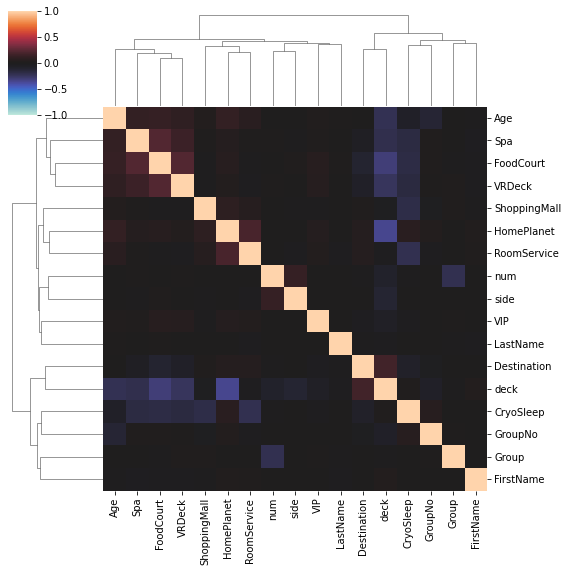

In [15]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        figsize=(8,8),
        **kwargs,
    )


corrplot(label_encode(X), annot=None)

# Deep Learning Modelling using Keras + Tensorflow

[TensorFlow](https://www.tensorflow.org/): free and open-source software library for machine learning and artificial intelligence.  
[Keras](https://keras.io/): **deep learning API written in Python**, running on top of TensorFlow.

We repeat some of the steps we performed earlier, so that this section can be run as a self-sufficient section without having to go through the details of the previous sections. This includes:
* Loading the data
* Cleaning, encoding and imputing
* Engineering some basic features

In [16]:
# Load-clean-encode-impute: Training + Test sets
df_train, df_test = load_data()

# Create features

# Training set
X = df_train.copy()
y = X.pop("Transported")
X = X.join(break_down(X))
X.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# Test set
X_test = df_test.copy()
X_test = X_test.join(break_down(X_test))
X_test.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

## Training preparations

* Separation of original training feature set into training and validation sets
* Basic data preprocessing using normalisation of numeric columns and one-hot-encoding of categorical columns
* Setting the input-shape of the feature set
* Initialising the model `keras.Sequential()`
* Setting early-stopping conditions

In [17]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

In [18]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, make_column_selector(dtype_include=np.number)),
    (transformer_cat, make_column_selector(dtype_include=object)),
)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.fit_transform(X_valid)

input_shape = [X_train.shape[1]]

In [19]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

2022-12-22 18:51:43.391909: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)


## Training

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=False,
)

2022-12-22 18:51:44.083367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [23]:
history_df = pd.DataFrame(history.history)

print("Minimum Training Loss: {:0.4f}".format(history_df['loss'].min()));
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
print('')
print("Maximum Training Accuracy: {:0.4f}".format(history_df['binary_accuracy'].max()));
print("Maximum Validation Accuracy: {:0.4f}".format(history_df['val_binary_accuracy'].max()));

Minimum Training Loss: 0.4636
Minimum Validation Loss: 0.4733

Maximum Training Accuracy: 0.7954
Maximum Validation Accuracy: 0.8004


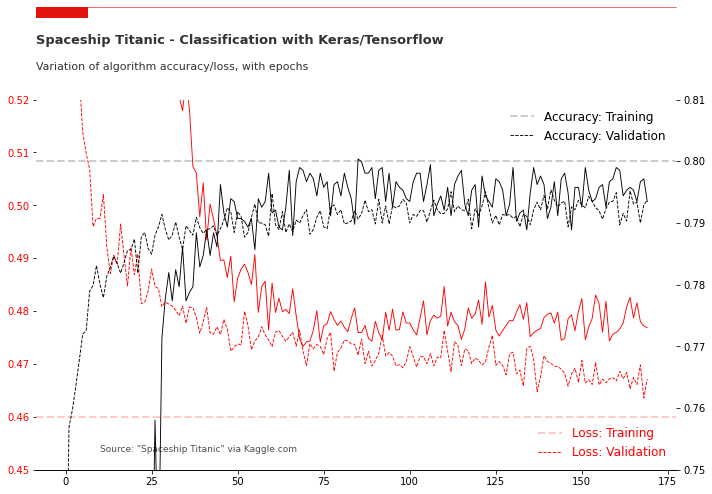

In [24]:
c = ['#ff0000', '#000000']

fig, ax = plt.subplots(figsize=(10,7))

ax.axhline(y=0.46, color=c[0], alpha=0.2, linestyle='dashed', lw=2)
history_df.loc[:, ['loss', 'val_loss']].plot(ax=ax, color=c[0], style=['--', '-'], linewidth=0.9)
ax.tick_params(axis='y', labelcolor=c[0])
ax.set_ylim([0.45, 0.52])
ax.legend(['Loss: Training', 'Loss: Validation'], loc='lower right', frameon=False, fontsize=12, labelcolor=c[0])
#ax.set_ylabel('Cross-Entropy', fontsize=14)
#ax.set_xlabel('Epochs', fontsize=14)

ax2 = ax.twinx() 
ax2.axhline(y=0.80, color=c[1], alpha=0.2, linestyle='dashed', lw=2)
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=ax2, color=c[1], style=['--', '-'], linewidth=0.9)
ax2.tick_params(axis='y', labelcolor=c[1])
ax2.set_ylim([0.75, 0.81])
ax2.legend(['Accuracy: Training', 'Accuracy: Validation'], loc='upper right', frameon=False, fontsize=12, labelcolor=c[1])
#ax2.set_ylabel('Accuracy', fontsize=14)

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left']].set_visible(False)
ax2.spines[['top','right','left']].set_visible(False)

# Add in line and tag
ax.plot([0, 1],                 # Set width of line
        [1.25, 1.25],                  # Set height of line
    transform=ax.transAxes,   # Set location relative to plot
    clip_on=False, 
    color='#E3120B', 
    linewidth=.6)
ax.add_patch(plt.Rectangle((0, 1.25),                 # Set location of rectangle by lower left corder
                        0.08,                       # Width of rectangle
                        -0.03,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=ax.transAxes, 
                        clip_on=False, 
                        linewidth = 0))

# Add in title and subtitle
ax.text(x=0, y=1.15, s="Spaceship Titanic - Classification with Keras/Tensorflow", transform=ax.transAxes, ha='left', fontsize=13, weight='bold', alpha=.8, fontname="Arial Black")
ax.text(x=0, y=1.08, s="Variation of algorithm accuracy/loss, with epochs", transform=ax.transAxes, ha='left', fontsize=11, alpha=.8, fontname="Arial Narrow")                         

# Set source text
ax.text(x=0.1, y=0.05, s="""Source: "Spaceship Titanic" via Kaggle.com""", transform=ax.transAxes, ha='left', fontsize=9, alpha=.7, fontname="Arial Narrow")

plt.tight_layout()

# Export plot as high resolution PNG
plt.savefig('cover_pic.png',    # Set path and filename
                dpi = 300,                          # Set dots per inch
                bbox_inches="tight",                # Remove extra whitespace around plot
                facecolor='white')                  # Set background color to white

## Prediction

In [25]:
X_test = preprocessor.transform(X_test)
predictions = model.predict(X_test)

predictions = pd.DataFrame(predictions, columns=['Transported'])
predictions = predictions.apply(lambda s: s // 0.5)

predictions['Transported'] = predictions['Transported'].map({0: False, 1: True})

## Submissions

In [26]:
submit = pd.DataFrame({'PassengerId':df_test.PassengerId, 'Transported':predictions.Transported})
submit.to_csv('submission.csv', index=False)
submit.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
